In [165]:
from algoritmos import *
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt, dates as md
from scipy.stats import probplot, ks_2samp, kstest

In [46]:
pedidos = pd.read_csv('./Dados/Exemplo.csv', parse_dates=['Início Preparo', 'Início Entrega', 'Término Entrega'])

In [48]:
pedidos = pedidos[pedidos['Início Entrega'].dt.day == 10]

In [49]:
pedidos['Hora Pedido'] = pedidos['Início Entrega'].dt.floor('1h').dt.strftime('%H:%M')

C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_15820\2842831171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedidos['Hora Pedido'] = pedidos['Início Entrega'].dt.floor('1h').dt.strftime('%H:%M')


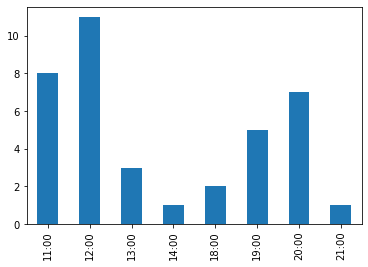

In [50]:
pedidos['Hora Pedido'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [95]:
t0 = dt.datetime(2023, 1, 10)
T = (pedidos['Início Entrega'] - t0).dt.total_seconds().values / 86400
b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
alfas_t = np.array([alfa_t(t, T, b) for t in T])
As_t = A_t_Riemann(T, b)

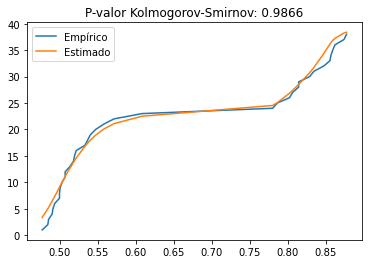

In [98]:
T.sort()
N = [len(T[T <= t]) for t in T]
plt.plot([t0 + dt.timedelta(seconds=t*86400) for t in T], N, label='Empírico')
plt.plot([t0 + dt.timedelta(seconds=t*86400) for t in T], As_t[1], label='Estimado')
plt.legend(loc='upper left')
plt.title('P-valor Kolmogorov-Smirnov: {}'.format(round(ks_2samp(N, As_t[1]).pvalue, 4)))
plt.show()

In [351]:
pedidos['TC'] = pedidos.apply(lambda x: (x['Término Entrega'] - x['Início Entrega']).total_seconds()  / 60 / 5 * 2, axis=1)
k, _, theta = gamma.fit(pedidos['TC'].values, floc=0)

C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_15820\3361810469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedidos['TC'] = pedidos.apply(lambda x: (x['Término Entrega'] - x['Início Entrega']).total_seconds()  / 60 / 5 * 2, axis=1)


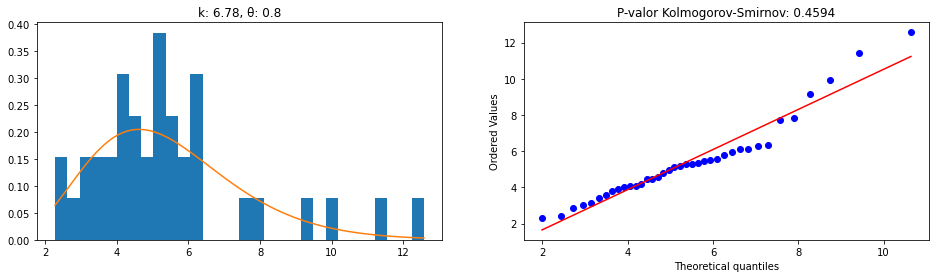

In [352]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))

ax1.hist(pedidos['TC'].values, bins=30, density=True)
x = np.linspace(*pedidos['TC'].agg(['min', 'max']), 100)
ax1.plot(x, gamma.pdf(x, k, loc=0, scale=theta))
ax1.set_title('k: {0}, θ: {1}'.format(round(k, 2), round(theta, 2)))

probplot(pedidos['TC'].values, (k, 0, theta), 'gamma', fit=True, plot=ax2)
ax2.set_title('P-valor Kolmogorov-Smirnov: {}'.format(round(kstest(pedidos['TC'].values, 'gamma', (k, _, theta)).pvalue, 4)))

plt.show()

In [297]:
def matriz_resultados(vetores_w, L):
    matriz = np.zeros((L + 1, L + 1), dtype=float)
    
    for n2, wm_wi_w1, p_wm_wi_w1 in vetores_w:
        matriz[n2, np.sum(wm_wi_w1)] += p_wm_wi_w1
        
    return matriz

In [298]:
def processo_fila(T, L, C, m, lamb, k, theta):
    probs_wt = []
    if C[0] == 0:
        matriz_sistema_vazio = np.zeros((L + 1, L + 1), dtype=float)
        matriz_sistema_vazio[0, 0] = 1.
        probs_wt.append((T[0], matriz_sistema_vazio))
    else:
        vetores_0 = (0, np.zeros((1, m), dtype=int), np.array([1.])),
        vetores_w, vetores_matriz = it.tee(gerar_vetores_w(vetores_0, L, C[0], m, lamb[0], k, theta))
        probs_wt.append((T[0], matriz_resultados(vetores_matriz, L)))
        vetores_prox_x = ordenar_vetores_w(somar_probs_w(vetores_w), m)

    for t, c, l in zip(T[1:], C[1:], lamb[1:]):
        if c == 0:
            matriz_sistema_vazio = np.zeros((L + 1, L + 1), dtype=float)
            matriz_sistema_vazio[0, 0] = 1.
            probs_wt.append((t, matriz_sistema_vazio))
            vetores_prox_x = (0, np.zeros((1, m), dtype=int), np.array([1.])),
            continue
            
        vetores_w, vetores_matriz = it.tee(gerar_vetores_w(vetores_prox_x, L, c, m, l, k, theta))
        probs_wt.append((t, matriz_resultados(vetores_matriz, L)))
        vetores_prox_x = ordenar_vetores_w(somar_probs_w(vetores_w), m)
        
    return probs_wt

In [299]:
momentos_fila = [(t0 + dt.timedelta(minutes=d) - t0).total_seconds() / 86400 for d in np.arange(1, 1440 / 5 + 1) * 5]
alfas_t_fila = np.array([alfa_t(t, T, b) for t in momentos_fila])

In [360]:
L = 30
m = 14
C1 = [0 if dt.datetime(2023, 1, 10, 0) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 10) else 1 for t in momentos_fila]
_lamb = alfas_t_fila[1:]
_theta = theta

probs_estab_c1 = processo_fila(momentos_fila, L, C1, m, _lamb, k, _theta)

In [361]:
L_c1 = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_c1]
Lq_c1 = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_c1, C1)]
Wq_c1 = Lq_c1 / _theta
Ws_c1 = L_c1 / _theta

In [363]:
L = 30
m = 14
C2 = [0 if dt.datetime(2023, 1, 10, 0) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 10) else 2 for t in momentos_fila]
_lamb = alfas_t_fila[1:]
_theta = theta

probs_estab_c2 = processo_fila(momentos_fila, L, C2, m, _lamb, k, _theta)

In [364]:
L_c2 = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_c2]
Lq_c2 = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_c2, C2)]
Wq_c2 = Lq_c2 / _theta
Ws_c2 = L_c2 / _theta

In [320]:
n_real = []

for t in momentos_fila:
    check = t0 + dt.timedelta(seconds=t * 86400)
    n = len(pedidos[((pedidos['Término Entrega'] > check) & (pedidos['Início Entrega'] <= check)) | 
              ((pedidos['Término Entrega'] >= check - dt.timedelta(minutes=5)) & (pedidos['Término Entrega'] < check))])
    n_real.append(n)

In [355]:
x = [t0 + dt.timedelta(seconds=t * 86400) for t in momentos_fila[1:]]

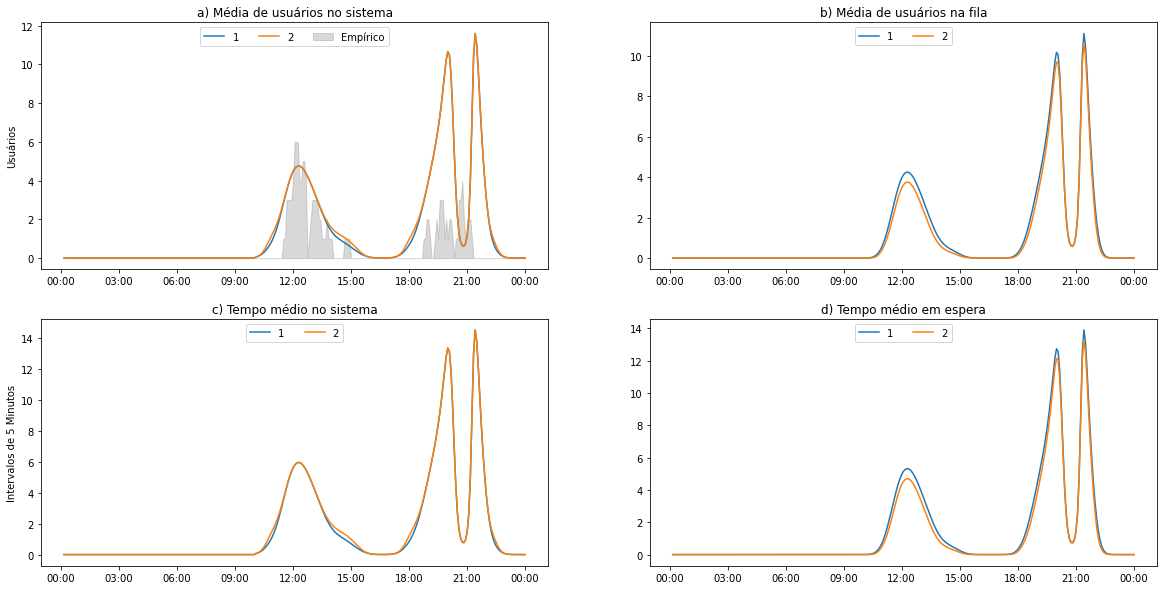

In [365]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

fmt = md.DateFormatter('%H:%M')

axs[0, 0].plot(x, L_c1, label='1')
axs[0, 0].plot(x, L_c2, label='2')
axs[0, 0].fill_between(x, n_real[1:], color='gray', alpha=.3, label='Empírico')
axs[0, 0].set_title('a) Média de usuários no sistema')
axs[0, 0].set_ylabel('Usuários')

axs[0, 1].plot(x, Lq_c1, label='1')
axs[0, 1].plot(x, Lq_c2, label='2')
axs[0, 1].set_title('b) Média de usuários na fila')

axs[1, 0].plot(x, Ws_c1, label='1')
axs[1, 0].plot(x, Ws_c2, label='2')
axs[1, 0].set_title('c) Tempo médio no sistema')
axs[1, 0].set_ylabel('Intervalos de 5 Minutos')

axs[1, 1].plot(x, Wq_c1, label='1')
axs[1, 1].plot(x, Wq_c2, label='2')
axs[1, 1].set_title('d) Tempo médio em espera')

for ax in axs.ravel(): 
    ax.xaxis.set_major_formatter(fmt)
    ax.legend(loc='upper center', ncol=4)